# Volatility Forecasting Model — Random Forest
**Author:** Dipak G. Sakharkar

Forecasts next-day realized volatility of S&P 500 index using a time-aware Random Forest approach.
- Target: Next-day 5-day realized volatility (annualized)
- Evaluation: Walk-forward TimeSeriesSplit (RMSE, MAE, R²)
- Features: Lag, rolling statistics, and volatility measures
- Implementation: Leakage-free, reproducible, and saved metrics/feature importances


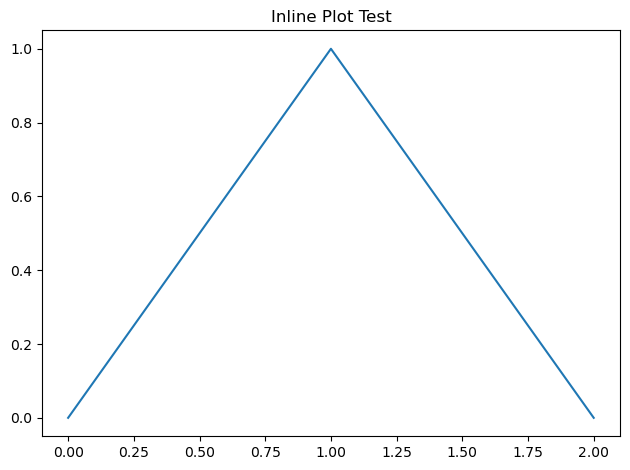

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# Inline Plot Test
plt.figure(); plt.plot([0,1,0]); plt.title('Inline Plot Test'); plt.tight_layout(); plt.show()


In [2]:
%matplotlib inline
# --- Setup (Verbose)
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math, os, glob

print("[step] Setup imports loaded.")

pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 50)

# Config
VOL_WINDOW = 5      # realized volatility window (days)
N_SPLITS   = 5      # time-series CV folds
RF_PARAMS  = dict(n_estimators=600, max_depth=None, min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1)
RECENT_N   = None   # set to e.g. 4000 to speed experiments; None = all

print(f"[config] VOL_WINDOW={VOL_WINDOW}, N_SPLITS={N_SPLITS}, RF_PARAMS={RF_PARAMS}, RECENT_N={RECENT_N}")

def candidate_paths():
    cwd = Path.cwd()
    env_dir = os.environ.get("DATA_PATH")
    paths = []
    if env_dir:
        paths += [
        cwd.parent/'data'/'SPX.csv',  # Added to match Richard's structure
Path(env_dir)/"SPX.csv"]
    paths += [
        cwd.parent/'data'/'SPX.csv',  # Added to match Richard's structure

        cwd/'SPX.csv',
        cwd/'data'/'SPX.csv',
        cwd.parent/'data'/'SPX.csv',
        Path('/mnt/data/SPX.csv'),
        Path('/mnt/data/SPX-checkpoint.csv'),
    ]
    globs = []
    for pat in ['SPX*.csv', 'spx*.csv', '*SP500*.csv', '*S&P*.csv']:
        globs += list(cwd.glob(pat))
        if (cwd/'data').exists():
            globs += list((cwd/'data').glob(pat))
    paths += globs
    # de-dup
    seen=set(); out=[]
    for p in paths:
        key = str(p.resolve()) if p.exists() else str(p)
        if key not in seen:
            out.append(p); seen.add(key)
    return out

def load_spx():
    print("[data] Searching for SPX.csv ...")
    checks = []
    for p in candidate_paths():
        checks.append(str(p))
        try:
            if p.exists() and p.is_file():
                df = pd.read_csv(p)
                df.columns = [c.strip().title().replace(' ', '') for c in df.columns]
                price_col = 'Adjclose' if 'Adjclose' in df.columns else ('AdjClose' if 'AdjClose' in df.columns else ('Close' if 'Close' in df.columns else None))
                if price_col is None:
                    continue
                px = pd.to_numeric(df[price_col], errors='coerce').dropna()
                if len(px) > 100:
                    print(f"[data] Loaded {len(px)} rows from: {p}")
                    return px
        except Exception as e:
            pass
    print("[data] Checked paths:")
    for p in checks: print("   -", p)
    raise FileNotFoundError("SPX.csv not found in the above locations. Place it next to this notebook, in ./data, or set DATA_PATH.")

px = load_spx()
if RECENT_N:
    px = px.iloc[-RECENT_N:]
print(f"[ok] Data ready. Length: {len(px)}")
len(px)


[step] Setup imports loaded.
[config] VOL_WINDOW=5, N_SPLITS=5, RF_PARAMS={'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}, RECENT_N=None
[data] Searching for SPX.csv ...
[data] Loaded 23323 rows from: /home/cameron/Documents/Dartmouth/Machine_Learning/ML-Team2-Project/data/SPX.csv
[ok] Data ready. Length: 23323


23323

## Target and Features (aligned)
We model **log-volatility** and back-transform for evaluation. All predictors are aligned so that only information available **up to time t** is used to predict **t+1**.

In [3]:
# --- Target & features (Verbose)
print("[step] Building target and features ...")
ret = np.log(px/px.shift(1))
vol = pd.Series(ret).rolling(VOL_WINDOW).std() * np.sqrt(252)

y_raw = vol.shift(-1)
y_log = np.log(y_raw.clip(lower=1e-10))

def rsum(r, w): return pd.Series(r).rolling(w).sum()
def rstd(r, w): return pd.Series(r).rolling(w).std()
def rmean(r, w): return pd.Series(r).rolling(w).mean()

X = pd.DataFrame({
    'ret_1': pd.Series(ret).shift(1),
    'ret_5_sum': rsum(ret,5).shift(1),
    'ret_5_std': rstd(ret,5).shift(1),
    'ret_21_std': rstd(ret,21).shift(1),
    'ret_21_mean': rmean(ret,21).shift(1),
    'vol_t': vol,
    'vol21_t': pd.Series(ret).rolling(21).std() * np.sqrt(252),
    'ret_abs_1': pd.Series(ret).abs().shift(1),
    'ret_sq_1': (pd.Series(ret)**2).shift(1),
}).dropna()

aligned = pd.concat([X, y_log], axis=1).dropna()
X, ylog = aligned[X.columns], aligned[y_log.name]

print(f"[ok] Features/target ready. X shape: {X.shape}, ylog shape: {ylog.shape}")
print("[peek] X.head():") 
display(X.head())
print("[peek] ylog.head():") 
display(ylog.head())

X.shape, ylog.shape


[step] Building target and features ...
[ok] Features/target ready. X shape: (23300, 9), ylog shape: (23300,)
[peek] X.head():


,ret_1,ret_5_sum,ret_5_std,ret_21_std,ret_21_mean,vol_t,vol21_t,ret_abs_1,ret_sq_1
22,0.004564,-7.936493e-03,0.008726,0.007660,-0.000243,0.113909,0.119849,0.004564,0.000021
23,-0.002279,5.706705e-04,0.007176,0.007550,-0.000621,0.112026,0.121630,0.002279,0.000005
24,0.005688,1.821460e-17,0.007057,0.007662,-0.000242,0.138722,0.125567,0.005688,0.000032
25,-0.013132,-1.652936e-02,0.008739,0.007910,-0.000409,0.122451,0.123843,0.013132,0.000172
26,0.002869,-2.289583e-03,0.007714,0.007801,-0.000570,0.114342,0.119902,0.002869,0.000008


[peek] ylog.head():


22   -2.189024
23   -1.975282
24   -2.100043
25   -2.168563
26   -2.138211
Name: AdjClose, dtype: float64

((23300, 9), (23300,))

## Walk-forward evaluation (TimeSeriesSplit)
We report RMSE/MAE/R² on the **original volatility scale** (after back-transform).

In [4]:
def walkforward_scores(X, ylog, n_splits=5, rf_params=None):
    if rf_params is None:
        rf_params = RF_PARAMS
    cv = TimeSeriesSplit(n_splits=n_splits)
    rmse, mae, r2 = [], [], []
    rows = []
    for k, (tr, va) in enumerate(cv.split(X), 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = ylog.iloc[tr], ylog.iloc[va]
        rf = RandomForestRegressor(**rf_params)
        rf.fit(Xtr, ytr)
        pred = np.asarray(np.exp(rf.predict(Xva)), dtype=float)
        true = np.asarray(np.exp(yva), dtype=float)
        rmse_k = float(np.sqrt(mean_squared_error(true, pred)))
        mae_k = float(mean_absolute_error(true, pred))
        ybar = float(true.mean())
        ss_res = float(((true - pred)**2).sum())
        ss_tot = float(((true - ybar)**2).sum())
        r2_k = float(1 - ss_res/ss_tot) if ss_tot > 0 else float('nan')
        rmse.append(rmse_k); mae.append(mae_k); r2.append(r2_k)
        rows.append({'fold': k, 'rmse': rmse_k, 'mae': mae_k, 'r2': r2_k,
                     'n_train': int(len(tr)), 'n_val': int(len(va))})
    summary = {
        'rmse_mean': float(np.mean(rmse)), 'rmse_std': float(np.std(rmse)),
        'mae_mean': float(np.mean(mae)),   'mae_std': float(np.std(mae)),
        'r2_mean': float(np.nanmean(r2))
    }
    return pd.DataFrame(rows), summary

print('[step] Running walk-forward evaluation ...')
fold_df, summary = walkforward_scores(X, ylog, n_splits=N_SPLITS, rf_params=RF_PARAMS)
print('[ok] CV complete. Summary:')
print(summary)
display(fold_df)
# Save artifacts
outdir = Path('experiments/results')
outdir.mkdir(parents=True, exist_ok=True)
fold_df.to_csv(outdir/'revF_cv_folds.csv', index=False)
pd.Series(summary).to_csv(outdir/'revF_cv_summary.csv')
print(f"[saved] {outdir/'revF_cv_folds.csv'}\n[saved] {outdir/'revF_cv_summary.csv'}")
summary

[step] Running walk-forward evaluation ...
[ok] CV complete. Summary:
{'rmse_mean': 0.038696556225088975, 'rmse_std': 0.007958366673046465, 'mae_mean': 0.023537686002888816, 'mae_std': 0.003447892885255539, 'r2_mean': 0.7995239045964837}


,fold,rmse,mae,r2,n_train,n_val
0,1,0.034946,0.022527,0.761785,3885,3883
1,2,0.026586,0.017646,0.803979,7768,3883
2,3,0.046527,0.024715,0.749085,11651,3883
3,4,0.037127,0.024676,0.804047,15534,3883
4,5,0.048297,0.028123,0.878723,19417,3883


[saved] experiments/results/revF_cv_folds.csv
[saved] experiments/results/revF_cv_summary.csv


{'rmse_mean': 0.038696556225088975,
 'rmse_std': 0.007958366673046465,
 'mae_mean': 0.023537686002888816,
 'mae_std': 0.003447892885255539,
 'r2_mean': 0.7995239045964837}

## Fit final model on full data
Use the configured RF on all available samples. You can later serialize the model if needed.

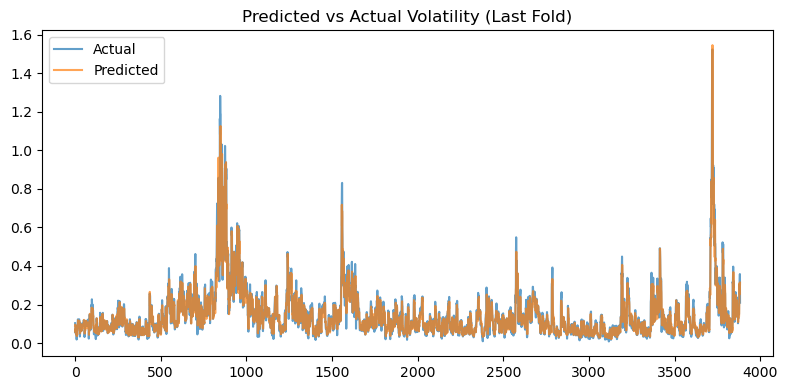

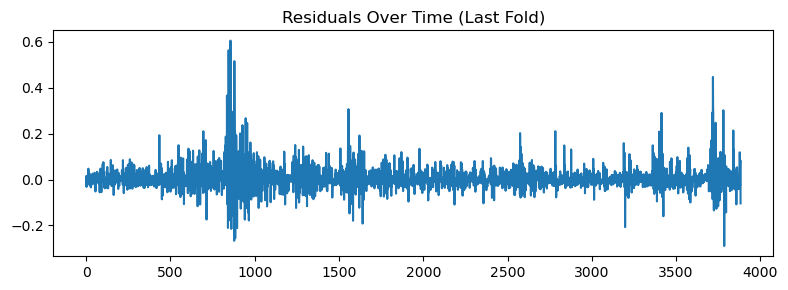

In [5]:
# --- Prediction vs Actual (last fold) and Residuals ---
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

cv = TimeSeriesSplit(n_splits=5)
last_tr, last_va = list(cv.split(X))[-1]
rf = RandomForestRegressor(**RF_PARAMS)
rf.fit(X.iloc[last_tr], ylog.iloc[last_tr])
pred = np.exp(rf.predict(X.iloc[last_va]))
true = np.exp(ylog.iloc[last_va])

plt.figure(figsize=(8,4))
plt.plot(true.values, label='Actual', alpha=0.7)
plt.plot(pred, label='Predicted', alpha=0.7)
plt.title('Predicted vs Actual Volatility (Last Fold)')
plt.legend()
plt.tight_layout()
from pathlib import Path
outdir = Path('experiments/results'); outdir.mkdir(parents=True, exist_ok=True)
plt.savefig(outdir/'rev5_pred_vs_actual.png')
plt.show()

# Residuals plot
resid = true - pred
plt.figure(figsize=(8,3))
plt.plot(resid.values)
plt.title('Residuals Over Time (Last Fold)')
plt.tight_layout()
from pathlib import Path
outdir = Path('experiments/results'); outdir.mkdir(parents=True, exist_ok=True)
plt.savefig(outdir/'rev5_residuals.png')
plt.show()

In [6]:
final_model = RandomForestRegressor(**RF_PARAMS).fit(X, ylog)
fi = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("[ok] Final model trained. Top features:")
display(fi.head(15).to_frame("importance"))
# Save
outdir = Path('experiments/results')
outdir.mkdir(parents=True, exist_ok=True)
fi.to_csv(outdir/'revF_feature_importance.csv', header=True)
print(f"[saved] {outdir/'revF_feature_importance.csv'}")
fi.head(15)

[ok] Final model trained. Top features:


,importance
vol_t,0.407913
ret_5_std,0.221772
vol21_t,0.138447
ret_21_std,0.081586
ret_sq_1,0.042073
ret_abs_1,0.040488
ret_5_sum,0.027030
ret_21_mean,0.023425
ret_1,0.017267


[saved] experiments/results/revF_feature_importance.csv


vol_t          0.407913
ret_5_std      0.221772
vol21_t        0.138447
ret_21_std     0.081586
ret_sq_1       0.042073
ret_abs_1      0.040488
ret_5_sum      0.027030
ret_21_mean    0.023425
ret_1          0.017267
dtype: float64

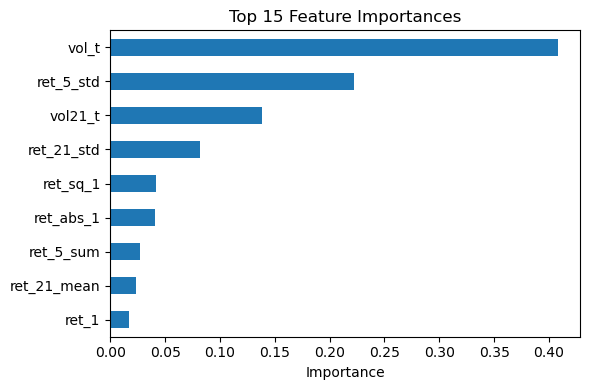

In [7]:
# --- Plot Feature Importances ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
fi.head(15).iloc[::-1].plot(kind='barh')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()

from pathlib import Path
outdir = Path('experiments/results'); outdir.mkdir(parents=True, exist_ok=True)
plt.savefig(outdir/'rev5_feature_importance.png')
plt.show()

In [8]:
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {
#     'n_estimators': [300, 600, 900],
#     'max_depth': [None, 6, 10, 14],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 0.5, 0.75],
# }
# cv = TimeSeriesSplit(n_splits=N_SPLITS)
# search = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
#                             param_distributions=param_dist, n_iter=20,
#                             scoring='neg_root_mean_squared_error', cv=cv,
#                             random_state=42, n_jobs=-1)
# search.fit(X, ylog)
# search.best_params_

,importance
vol_t,0.407913
ret_5_std,0.221772
vol21_t,0.138447
ret_21_std,0.081586
ret_sq_1,0.042073
ret_abs_1,0.040488
ret_5_sum,0.027030
ret_21_mean,0.023425
ret_1,0.017267


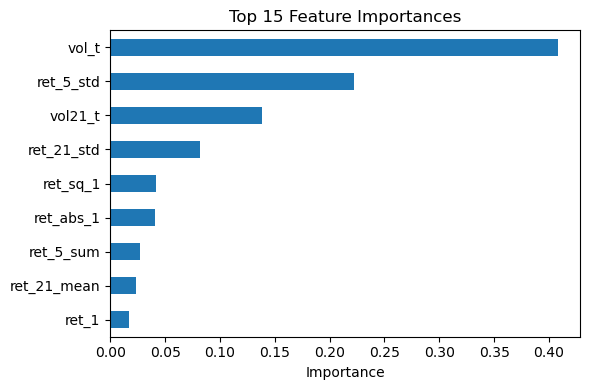

In [9]:
# --- Plot Feature Importances (uses trained model or saved CSV) ---
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
fi = None
try:
    fi = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
except Exception:
    # Fall back to CSV produced earlier versions
    outdir = Path('experiments/results')
    csv_path = outdir/'revL_feature_importance.csv'
    if csv_path.exists():
        tmp = pd.read_csv(csv_path)
        if tmp.shape[1] >= 2:
            fi = pd.Series(tmp.iloc[:,1].values, index=tmp.iloc[:,0].values).sort_values(ascending=False)
if fi is not None:
    display(fi.head(15).to_frame('importance'))
    plt.figure(figsize=(6,4))
    fi.head(15).iloc[::-1].plot(kind='barh')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout(); plt.show()
else:
    print('Feature importance not available — run the training cell first.')


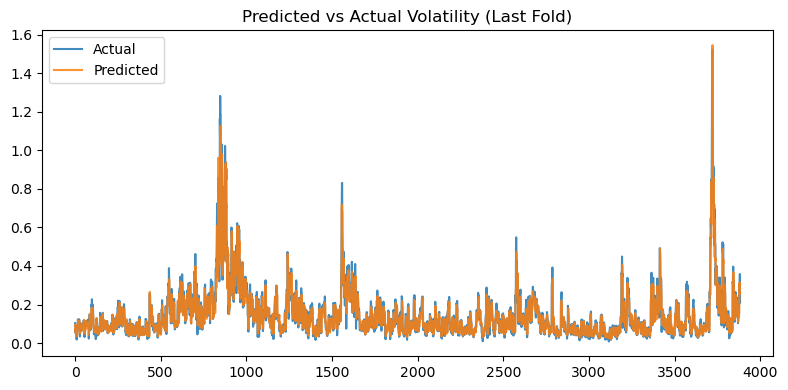

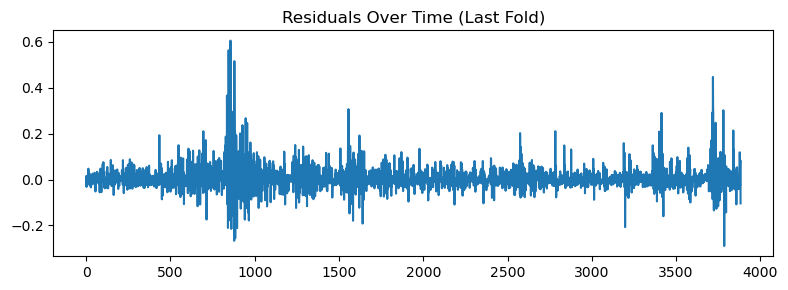

In [10]:
# --- Predicted vs Actual & Residuals (last fold) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
try:
    cv = TimeSeriesSplit(n_splits=5)
    last_tr, last_va = list(cv.split(X))[-1]
    model = RandomForestRegressor(**RF_PARAMS)
    model.fit(X.iloc[last_tr], ylog.iloc[last_tr])
    pred = np.exp(model.predict(X.iloc[last_va]))
    true = np.exp(ylog.iloc[last_va])
    plt.figure(figsize=(8,4))
    plt.plot(true.values, label='Actual', alpha=0.85)
    plt.plot(pred, label='Predicted', alpha=0.85)
    plt.title('Predicted vs Actual Volatility (Last Fold)')
    plt.legend(); plt.tight_layout(); plt.show()
    resid = true - pred
    plt.figure(figsize=(8,3))
    plt.plot(resid.values)
    plt.title('Residuals Over Time (Last Fold)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Run the data/feature/training cells first — plotting skipped. Error:', e)
